# Calibration Diagnostic

In [1]:
# These are the defaults for the run. They are overwritten on command-line.
observation = '/data5/edges/data/CalibrationObservations/Receiver01/Receiver01_25C_2019_11_26_040_to_200MHz'
wterms = 7
cterms = 7
f_low = 40
f_high = None
run_num = None
repeat_num = None
resistance_f = 50.009
load_kwargs = None
s11_kwargs = None
load_spectra = None
load_s11s = None
compile_from_def = True
include_previous = False

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
from datetime import datetime
import edges_io as eio
import edges_cal as ec
from pathlib import Path
import yaml
import warnings
from beautifultable import BeautifulTable

This document shows the results of calibration for: 

In [3]:
obspath = Path(observation).absolute()
print("Observation Location: ", obspath)

print("Date Run: ", datetime.now())
print("Version of edges-io:", eio.__version__)
print("Version of edges-cal:", ec.__version__)


Observation Location:  /data5/edges/data/CalibrationObservations/Receiver01/Receiver01_25C_2019_11_26_040_to_200MHz
Date Run:  2020-12-14 13:45:30.167420
Version of edges-io: 0.0.post0.dev1+g97f97d7
Version of edges-cal: 0.0.post0.dev1+g319afab


In [12]:
calobs = ec.CalibrationObservation(
    obspath,
    wterms = wterms,
    cterms = cterms,
    f_low = f_low,
    f_high = f_high,
    run_num = run_num,
    repeat_num = repeat_num,
    resistance_f = resistance_f,
    load_kwargs = load_kwargs,
    s11_kwargs = s11_kwargs,
    load_spectra = load_spectra,
    load_s11s = load_s11s,
    compile_from_def = compile_from_def,
    include_previous = include_previous,
)
antsims = {name: calobs.new_load(name) for name in calobs.io.simulator_names}

## Observation Metadata

The following metadata fully defines this calibration for this version of `edges-cal`:

In [27]:
if compile_from_def and calobs.path != obspath:
    if calobs.io.definition:
        print(f"> Compiled from definition file. Definition:\n{yaml.dump(calobs.io.definition)}", end= ' ')
    else:
        print("> Compiled from empty definition file.", end= ' ')
else:
    print("> Not compiled from definition file.", end= ' ')
if include_previous:
    print("Includes data from previous observations if necessary.")
else:
    print("Does not include data from previous observations.")
print()

table = BeautifulTable()
table.rows.append(['wterms', calobs.wterms, 'cterms', calobs.cterms])
table.rows.append(['f_min', f"{calobs.freq.min:.2f} MHz", 'f_max', f"{calobs.freq.max:.2f} MHz"])
table.rows.append(['LNA Res.', f"{calobs.lna.resistance} Ohms", "LNA S11 nterms", calobs.lna.n_terms])
print(table)
print()

table = BeautifulTable()
table.columns.header = [
    'S11 Run', 
    'Spec/Res. Run', 
    'S11 Rep.', 
    'Ignored %', 
    'Male Res. (Ohms)',
    'S11 nterms',
    'xRFI'
]
sources = []
for name, source in calobs._loads.items():
    sources.append(name)
    table.rows.append([
        source.reflections.run_num,
        source.spectrum.run_num,
        calobs.io.s11.repeat_num[name],
        source.spectrum.ignore_times_percent,
        source.reflections.resistance,
        source.reflections.n_terms,
        source.spectrum.rfi_removal
    ])
table.rows.header = sources
print(table)

print()
print("Antenna Simulators Available:", ', '.join(sorted(calobs.io.simulator_names)))

> Compiled from empty definition file. Does not include data from previous observations.

+----------+-------------+----------------+------------+
|  wterms  |      7      |     cterms     |     7      |
+----------+-------------+----------------+------------+
|  f_min   |  40.00 MHz  |     f_max      | 199.99 MHz |
+----------+-------------+----------------+------------+
| LNA Res. | 50.009 Ohms | LNA S11 nterms |     37     |
+----------+-------------+----------------+------------+

+-------+-------+-----------+-------+--------+----------------+---------+------+
|       | S11 R | Spec/Res. | S11 R | Ignore | Male Res. (Ohm | S11 nte | xRFI |
|       |  un   |    Run    |  ep.  |  d %   |       s)       |   rms   |      |
+-------+-------+-----------+-------+--------+----------------+---------+------+
| ambie |   2   |     1     |   1   |  5.0   |     50.166     |   37    | 1D2D |
|  nt   |       |           |       |        |                |         |      |
+-------+-------+-------

## Spectrum Data

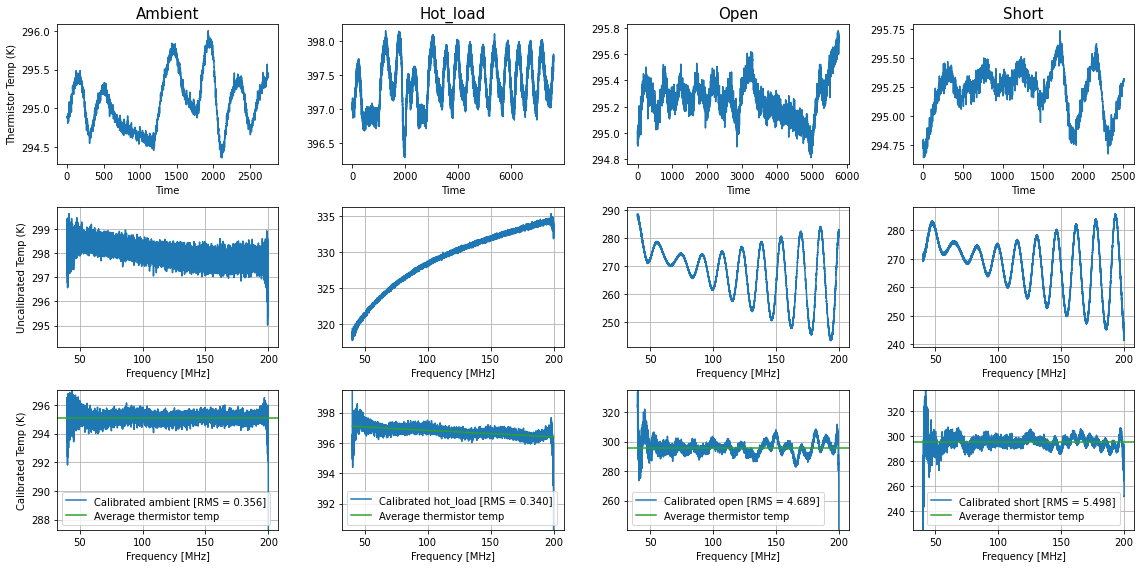

In [21]:
fig, ax = plt.subplots(
    3,4,figsize=(16,8), 
    #gridspec_kw={"hspace":0.05, 'wspace':0.05}
)

for i, (name, load) in enumerate(calobs._loads.items()):
    ax[0,i].plot(load.spectrum.thermistor_temp)
    ax[0,i].set_title(name.capitalize(), fontsize=15)
    ax[0,i].set_xlabel("Time")
    load.spectrum.plot(fig=fig, ax=ax[1,i],ylabel=False)
    calobs.plot_calibrated_temp(load, ax=ax[2,i],ylabel=False)
    
ax[0,0].set_ylabel("Thermistor Temp (K)")
ax[1,0].set_ylabel("Uncalibrated Temp (K)")
ax[2,0].set_ylabel("Calibrated Temp (K)")

plt.tight_layout()

**Figure 1 | Spectrum Measurements.** Each column is a known input calibrator source. Top row is the measured thermistor temperature in K as a function of time (in number of integrations). Second row is the *uncalibrated* measured temperature of the spectrum, as a function of frequency. The third row is the *calibrated* temperature (see figure 5 for the calibration coefficients) shown against the average thermistor temperature across the band.

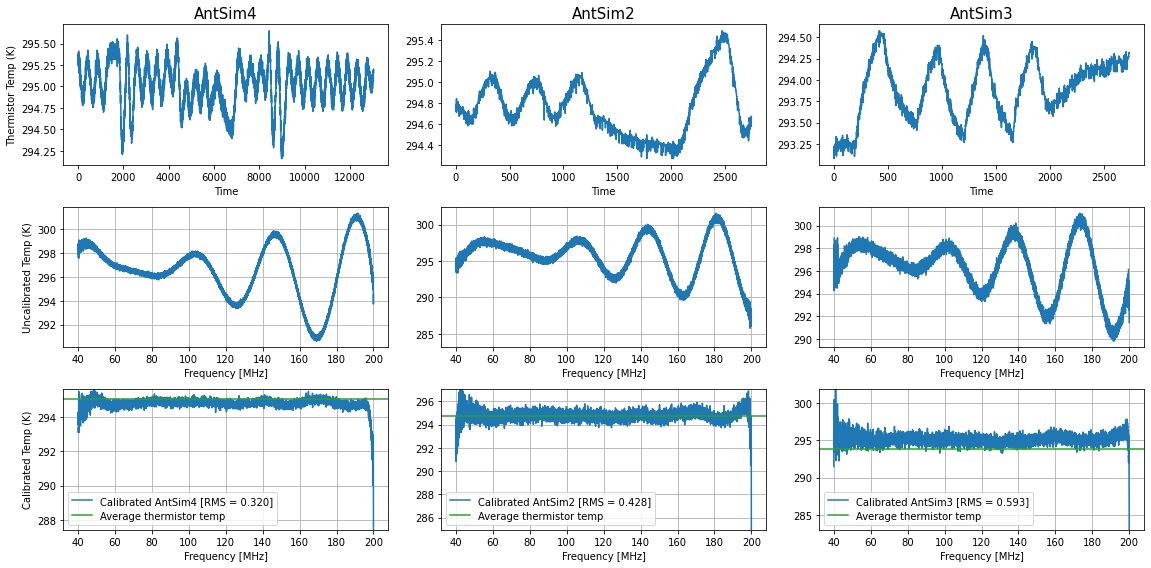

In [22]:
fig, ax = plt.subplots(
    3,3,figsize=(16,8), 
)

for i, (name, load) in enumerate(antsims.items()):
    ax[0,i].plot(load.spectrum.thermistor_temp)
    ax[0,i].set_title(name, fontsize=15)
    ax[0,i].set_xlabel("Time")
    load.spectrum.plot(fig=fig, ax=ax[1,i],ylabel=False)
    calobs.plot_calibrated_temp(load, ax=ax[2,i],ylabel=False)
    
ax[0,0].set_ylabel("Thermistor Temp (K)")
ax[1,0].set_ylabel("Uncalibrated Temp (K)")
ax[2,0].set_ylabel("Calibrated Temp (K)")

plt.tight_layout()

**Figure 2 | Antenna Simulator Spectra.** This plot shows the same measurements as Figure 1, but for the antenna simulators measured in this calibration.

## S11

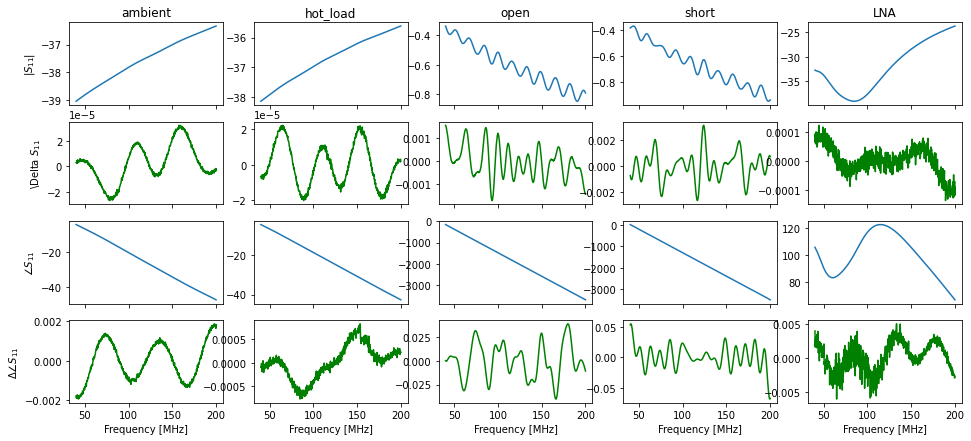

In [7]:
fig, ax = plt.subplots(4,5, sharex=True, figsize=(16, 7))
warnings.filterwarnings("ignore", category=DeprecationWarning)

for i, (name, source) in enumerate(calobs._loads.items()):
    source.reflections.plot_residuals(fig=fig, ax=ax[:,i], title=False, decade_ticks=False,ylabels=not i)
    ax[0,i].set_title(name)
    
calobs.lna.plot_residuals(fig=fig, ax=ax[:,-1], title=False, decade_ticks=False,ylabels=False)
ax[0,-1].set_title("LNA");

**Figure 3 | Reflection Measurements.** This shows the reflection coefficient, $S_{11}$, for each input calibrator (columns). Top row shows the measured magnitude, second row the error in the model of the magnitude, the third row shows the phase angle and the bottom row shows the error in the magnitude of the phase. 

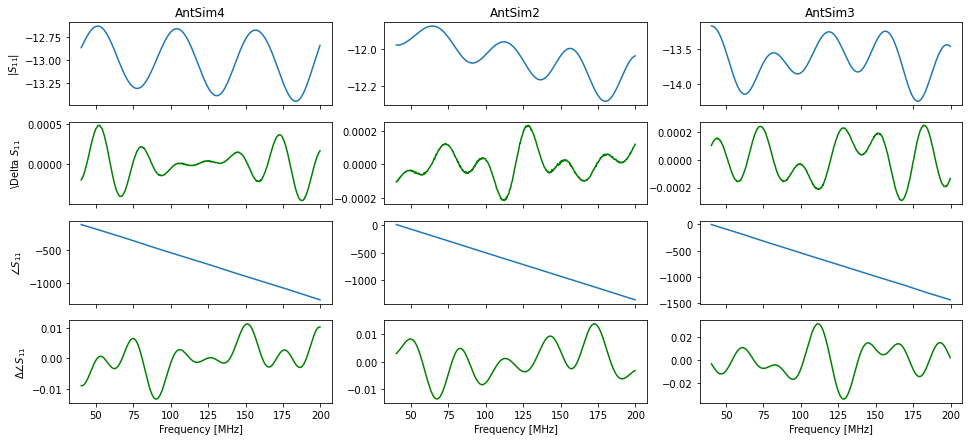

In [20]:
fig, ax = plt.subplots(4,3, sharex=True, figsize=(16, 7))
warnings.filterwarnings("ignore", category=DeprecationWarning)

for i, (name, source) in enumerate(antsims.items()):
    source.reflections.plot_residuals(fig=fig, ax=ax[:,i], title=False, decade_ticks=False,ylabels=not i)
    ax[0,i].set_title(name)

**Figure 4 | Antenna Simulator Reflection Coefficients.** The same as Fig. 3, but for the antenna simulators measured for this calibration observation.

## Calibration

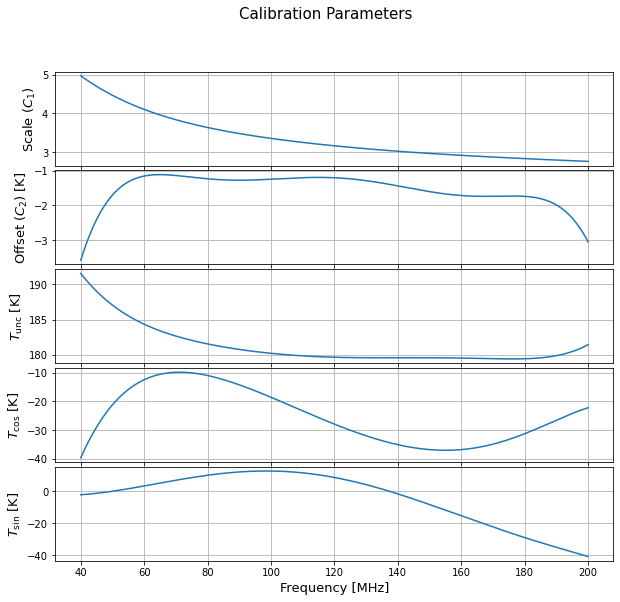

In [11]:
calobs.plot_coefficients();

**Figure 5 | Calibration Coefficients.** This shows the calibration coefficients as a function of frequency, as measured by optimizing the RMS of the calibrated temperatures of the input calibrator sources. The top row shows the overall scaling of the temperature required, the second row shows the overall offset, and the third, fourth and fifth rows show the noise-wave parameters (uncorrelated, cosine and sine).

## All Files Used

In [85]:
import os
def list_files(startpath, filter_list):
    for root, dirs, files in os.walk(startpath):
        level = root.replace(str(startpath), '').count(os.sep)
        indent = ' ' * 4 * (level)
        ff = [f for f in files if any(str(x).startswith(str(Path(root)/f)) for x in filter_list)]
        dd = [d for d in dirs if any(str(x).startswith(str(Path(root)/d)) for x in filter_list)]
        if ff or dd:
            print('{}{}/'.format(indent, os.path.basename(root)))
        if ff:
            subindent = ' ' * 4 * (level + 1)
            for f in ff:
                print('{}{}'.format(subindent, f))

In [86]:
fl = calobs.io.list_of_files[0]
list_files(Path(fl.joinpath(*fl.parts[:3])), calobs.io.list_of_files)

tmpq4505mnx/
    Receiver01_25C_2019_11_26_040_to_200MHz/
        Spectra/
            HotLoad_01_2019_330_23_38_05_lab.acq
            HotLoad_01_2019_332_00_00_34_lab.acq
            LongCableOpen_01_2019_335_00_00_06_lab.acq
            LongCableShorted_01_2019_334_00_00_32_lab.acq
            LongCableOpen_01_2019_336_00_00_16_lab.acq
            LongCableOpen_01_2019_334_18_43_21_lab.acq
            Ambient_01_2019_330_00_00_00_lab.acq
            Ambient_01_2019_329_23_01_16_lab.acq
            LongCableShorted_01_2019_333_20_17_28_lab.acq
            HotLoad_01_2019_333_00_00_01_lab.acq
            HotLoad_01_2019_331_00_00_23_lab.acq
        Resistance/
            HotLoad_01_2019_330_16_38_16_lab.csv
            LongCableOpen_01_2019_334_11_43_15_lab.csv
            Ambient_01_2019_329_16_02_35_lab.csv
            LongCableShorted_01_2019_333_13_17_29_lab.csv
        S11/
            Ambient01/
                Open02.s1p
                Short02.s1p
                External02.s